In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras.preprocessing.image import ImageDataGenerator 

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Data preparation

Read CSV and create data iterators for models

In [2]:
def append_ext(fn):
    return fn+".jpg"

In [3]:
meta = pd.read_csv('/kaggle/input/petfinder-pawpularity-score/train.csv')
labels = meta[['Id','Pawpularity']]
labels["Id"] = labels["Id"].apply(append_ext)
labels.to_csv('labels.csv',encoding='utf-8', index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Data iterators

In [4]:
def load_train(path):
    labels = pd.read_csv('./labels.csv')
       
    train_datagen = ImageDataGenerator(validation_split = 0.25, 
                                   rescale = 1/255.
                                   #vertical_flip = True, 
                                   #horizontal_flip = True,
                                   #rotation_range = 45,
                                   #width_shift_range=0.05,
                                   #height_shift_range=0.05
    )
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path +'train/',
        x_col='Id',
        y_col='Pawpularity',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=42)

    return train_gen_flow

In [5]:
def load_test(path):
    labels = pd.read_csv('./labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    
# flow_from_dataframe -> Takes the dataframe and the path to a directory + generates batches.
# The generated batches contain augmented/normalized data.
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'train/',
        x_col = 'Id',
        y_col = 'Pawpularity',
        target_size = (150, 150),
        batch_size = 32,
        class_mode = 'raw',
        subset = 'validation',
        seed = 42)

    return test_gen_flow

In [6]:
path = '/kaggle/input/petfinder-pawpularity-score/'
train_gen_flow = load_train(path)

Found 7434 validated image filenames.


In [7]:
path = '/kaggle/input/petfinder-pawpularity-score/'
valid_gen_flow = load_test(path)

Found 2478 validated image filenames.


### Check that data iterators work

In [8]:
f, t = next(train_gen_flow)

In [9]:
len(train_gen_flow)

465

In [10]:
f[0][0][0]

array([0.91372555, 0.882353  , 0.8313726 ], dtype=float32)

# Choose layers of pre-trained models to experiment with

## Architecture of ResNet50

![image.png](https://www.researchgate.net/publication/338603223/figure/fig1/AS:847598516711425@1579094642237/ResNet-50-architecture-26-shown-with-the-residual-units-the-size-of-the-filters-and.png)

In [11]:
base_ResNet50 = ResNet50(weights='imagenet')

2021-11-28 13:34:52.625943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 13:34:52.743060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 13:34:52.744227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 13:34:52.745822: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

102981632/102967424 [==============================] - 1s 0us/step


In [12]:
resnet_layers = [layer.name for layer in base_ResNet50.layers] 

In [13]:
df = pd.DataFrame(resnet_layers)
df.tail()

,0
172,conv5_block3_3_bn
173,conv5_block3_add
174,conv5_block3_out
175,avg_pool
176,predictions


In [14]:
df.iloc[142]

0    conv4_block6_out
Name: 142, dtype: object

# ResNet we will try 2 layers to extract features:

* 174 - conv5_block3_out
* 142 - conv4_block6_out

# Architecture of VGG 16 & VGG19

![](https://www.researchgate.net/publication/343048987/figure/fig2/AS:915587811262464@1595304553039/Architecture-of-Vgg16-and-Vgg19-31.png)

### VGG19

In [15]:
base_VGG19 = VGG19(weights='imagenet')

574726144/574710816 [==============================] - 11s 0us/step


VGG19 layers to try
* block5_pool
* block4_pool
* block3_pool

In [16]:
# Code exmaple of how to slice CNN architecture
VGG19_layer = Model(inputs=base_VGG19.input, outputs=base_VGG19.get_layer('block3_pool').output)

In [17]:
VGG19_layer.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### VGG16

In [18]:
base_VGG16 = VGG16(weights='imagenet')

553476096/553467096 [==============================] - 4s 0us/step


From VGG16 we are experimenting with next layers: 
* block5_pool
* block4_pool
* block3_pool

In [19]:
VGG16_layers = [layer.name for layer in base_VGG16.layers]

# Main function for the experiment


### Final architectures
Layered model + GlobalAveragePooling2D + Dense(1, activation='relu')

In [20]:
def layers_assessment(train, valid, pre_trained_model, layer, epochs):
    
    tqdm_callback = tfa.callbacks.TQDMProgressBar()
    
    base_model = pre_trained_model(weights='imagenet', 
                        input_shape=(150, 150, 3),
                        include_top=False)
    
    layered_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer).output)
    print(f"Layer {layer} has been loaded")
    #features = layered_model.predict(train)
    #print(features.shape)
    layered_model.trainable = False

    model = Sequential()
    model.add(layered_model)
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer,loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    #if steps_per_epoch is None:
    steps_per_epoch = len(train)
    #if validation_steps is None:
    validation_steps = len(valid)

    results = model.fit(train, 
              validation_data = valid,
              batch_size = 32, 
              epochs = epochs,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps,
              verbose = 1
              #callbacks=[tqdm_callback]
                       )
    return results 

# Experiments

In [21]:
epoch = 30

## ResNet50

In [22]:
results_ResNet_conv5 = layers_assessment(train_gen_flow, valid_gen_flow, ResNet50, 'conv5_block3_out', epoch)

94781440/94765736 [==============================] - 1s 0us/step
Layer conv5_block3_out has been loaded


2021-11-28 13:35:22.704577: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2021-11-28 13:35:27.879634: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


465/465 [==============================] - 163s 327ms/step - loss: 486.8489 - root_mean_squared_error: 22.0647 - val_loss: 453.6441 - val_root_mean_squared_error: 21.2989
Epoch 2/30
465/465 [==============================] - 118s 255ms/step - loss: 415.5348 - root_mean_squared_error: 20.3847 - val_loss: 453.2552 - val_root_mean_squared_error: 21.2898
Epoch 3/30
465/465 [==============================] - 117s 252ms/step - loss: 414.5188 - root_mean_squared_error: 20.3597 - val_loss: 452.9872 - val_root_mean_squared_error: 21.2835
Epoch 4/30
465/465 [==============================] - 117s 251ms/step - loss: 415.3806 - root_mean_squared_error: 20.3809 - val_loss: 451.8558 - val_root_mean_squared_error: 21.2569
Epoch 5/30
465/465 [==============================] - 116s 250ms/step - loss: 414.9262 - root_mean_squared_error: 20.3697 - val_loss: 450.5986 - val_root_mean_squared_error: 21.2273
Epoch 6/30
465/465 [==============================] - 117s 253ms/step - loss: 414.1472 - root_mean_sq

In [23]:
results_ResNet_conv4 = layers_assessment(train_gen_flow, valid_gen_flow, ResNet50, 'conv4_block6_out', epoch)

Layer conv4_block6_out has been loaded
Epoch 1/30
465/465 [==============================] - 117s 247ms/step - loss: 1838.7101 - root_mean_squared_error: 42.8802 - val_loss: 726.4268 - val_root_mean_squared_error: 26.9523
Epoch 2/30
465/465 [==============================] - 115s 246ms/step - loss: 425.2691 - root_mean_squared_error: 20.6221 - val_loss: 452.9351 - val_root_mean_squared_error: 21.2823
Epoch 3/30
465/465 [==============================] - 114s 246ms/step - loss: 418.6462 - root_mean_squared_error: 20.4608 - val_loss: 460.9499 - val_root_mean_squared_error: 21.4697
Epoch 4/30
465/465 [==============================] - 114s 246ms/step - loss: 423.0179 - root_mean_squared_error: 20.5674 - val_loss: 450.4284 - val_root_mean_squared_error: 21.2233
Epoch 5/30
465/465 [==============================] - 115s 247ms/step - loss: 423.1262 - root_mean_squared_error: 20.5700 - val_loss: 458.2969 - val_root_mean_squared_error: 21.4079
Epoch 6/30
465/465 [==============================

## VGG19

In [24]:
results_VGG19_block5 = layers_assessment(train_gen_flow, valid_gen_flow, VGG19, 'block5_pool', epoch)

80150528/80134624 [==============================] - 1s 0us/step
Layer block5_pool has been loaded
Epoch 1/30
465/465 [==============================] - 126s 268ms/step - loss: 503.3009 - root_mean_squared_error: 22.4344 - val_loss: 456.7262 - val_root_mean_squared_error: 21.3712
Epoch 2/30
465/465 [==============================] - 121s 260ms/step - loss: 414.2474 - root_mean_squared_error: 20.3531 - val_loss: 445.2573 - val_root_mean_squared_error: 21.1011
Epoch 3/30
465/465 [==============================] - 121s 261ms/step - loss: 405.4359 - root_mean_squared_error: 20.1354 - val_loss: 440.4198 - val_root_mean_squared_error: 20.9862
Epoch 4/30
465/465 [==============================] - 121s 260ms/step - loss: 400.8156 - root_mean_squared_error: 20.0204 - val_loss: 437.5831 - val_root_mean_squared_error: 20.9185
Epoch 5/30
465/465 [==============================] - 121s 260ms/step - loss: 397.7090 - root_mean_squared_error: 19.9426 - val_loss: 436.9038 - val_root_mean_squared_error:

In [25]:
results_VGG19_block4 = layers_assessment(train_gen_flow, valid_gen_flow, VGG19, 'block4_pool', epoch)

Layer block4_pool has been loaded
Epoch 1/30
465/465 [==============================] - 122s 261ms/step - loss: 438.9580 - root_mean_squared_error: 20.9513 - val_loss: 446.6982 - val_root_mean_squared_error: 21.1352
Epoch 2/30
465/465 [==============================] - 120s 258ms/step - loss: 415.1490 - root_mean_squared_error: 20.3752 - val_loss: 463.1264 - val_root_mean_squared_error: 21.5204
Epoch 3/30
465/465 [==============================] - 120s 257ms/step - loss: 406.0840 - root_mean_squared_error: 20.1515 - val_loss: 436.0443 - val_root_mean_squared_error: 20.8817
Epoch 4/30
465/465 [==============================] - 120s 258ms/step - loss: 402.8311 - root_mean_squared_error: 20.0707 - val_loss: 437.3903 - val_root_mean_squared_error: 20.9139
Epoch 5/30
465/465 [==============================] - 119s 255ms/step - loss: 398.3316 - root_mean_squared_error: 19.9582 - val_loss: 431.9505 - val_root_mean_squared_error: 20.7834
Epoch 6/30
465/465 [==============================] - 12

In [26]:
results_VGG19_block3 = layers_assessment(train_gen_flow, valid_gen_flow, VGG19, 'block3_pool', epoch)

Layer block3_pool has been loaded
Epoch 1/30
465/465 [==============================] - 121s 260ms/step - loss: 444.0284 - root_mean_squared_error: 21.0720 - val_loss: 461.7495 - val_root_mean_squared_error: 21.4884
Epoch 2/30
465/465 [==============================] - 116s 250ms/step - loss: 441.7975 - root_mean_squared_error: 21.0190 - val_loss: 447.3765 - val_root_mean_squared_error: 21.1513
Epoch 3/30
465/465 [==============================] - 110s 236ms/step - loss: 435.0661 - root_mean_squared_error: 20.8582 - val_loss: 517.1453 - val_root_mean_squared_error: 22.7408
Epoch 4/30
465/465 [==============================] - 112s 241ms/step - loss: 433.9677 - root_mean_squared_error: 20.8319 - val_loss: 546.2488 - val_root_mean_squared_error: 23.3720
Epoch 5/30
465/465 [==============================] - 112s 241ms/step - loss: 440.5962 - root_mean_squared_error: 20.9904 - val_loss: 523.2510 - val_root_mean_squared_error: 22.8747
Epoch 6/30
465/465 [==============================] - 11

## VGG16

In [27]:
results_VGG16_block5 = layers_assessment(train_gen_flow, valid_gen_flow, VGG16, 'block5_pool', epoch)

58900480/58889256 [==============================] - 1s 0us/step
Layer block5_pool has been loaded
Epoch 1/30
465/465 [==============================] - 116s 248ms/step - loss: 528.5411 - root_mean_squared_error: 22.9900 - val_loss: 458.1064 - val_root_mean_squared_error: 21.4034
Epoch 2/30
465/465 [==============================] - 115s 248ms/step - loss: 411.0680 - root_mean_squared_error: 20.2748 - val_loss: 445.2073 - val_root_mean_squared_error: 21.0999
Epoch 3/30
465/465 [==============================] - 116s 249ms/step - loss: 399.3177 - root_mean_squared_error: 19.9829 - val_loss: 438.7237 - val_root_mean_squared_error: 20.9457
Epoch 4/30
465/465 [==============================] - 115s 247ms/step - loss: 392.9618 - root_mean_squared_error: 19.8233 - val_loss: 436.1317 - val_root_mean_squared_error: 20.8838
Epoch 5/30
465/465 [==============================] - 113s 244ms/step - loss: 389.5309 - root_mean_squared_error: 19.7365 - val_loss: 433.7527 - val_root_mean_squared_error:

In [28]:
results_VGG16_block4 = layers_assessment(train_gen_flow, valid_gen_flow, VGG16, 'block4_pool', epoch)

Layer block4_pool has been loaded
Epoch 1/30
465/465 [==============================] - 111s 238ms/step - loss: 451.2836 - root_mean_squared_error: 21.2434 - val_loss: 454.7480 - val_root_mean_squared_error: 21.3248
Epoch 2/30
465/465 [==============================] - 115s 247ms/step - loss: 405.1102 - root_mean_squared_error: 20.1273 - val_loss: 440.3197 - val_root_mean_squared_error: 20.9838
Epoch 3/30
465/465 [==============================] - 121s 260ms/step - loss: 398.9566 - root_mean_squared_error: 19.9739 - val_loss: 455.1744 - val_root_mean_squared_error: 21.3348
Epoch 4/30
465/465 [==============================] - 117s 252ms/step - loss: 394.4614 - root_mean_squared_error: 19.8611 - val_loss: 433.0796 - val_root_mean_squared_error: 20.8106
Epoch 5/30
465/465 [==============================] - 117s 253ms/step - loss: 390.9944 - root_mean_squared_error: 19.7736 - val_loss: 432.9828 - val_root_mean_squared_error: 20.8082
Epoch 6/30
465/465 [==============================] - 11

In [29]:
results_VGG16_block3 = layers_assessment(train_gen_flow, valid_gen_flow, VGG16, 'block3_pool', epoch)

Layer block3_pool has been loaded
Epoch 1/30
465/465 [==============================] - 122s 261ms/step - loss: 438.6198 - root_mean_squared_error: 20.9433 - val_loss: 449.9224 - val_root_mean_squared_error: 21.2114
Epoch 2/30
465/465 [==============================] - 121s 260ms/step - loss: 423.8514 - root_mean_squared_error: 20.5877 - val_loss: 447.2361 - val_root_mean_squared_error: 21.1480
Epoch 3/30
465/465 [==============================] - 121s 259ms/step - loss: 420.1841 - root_mean_squared_error: 20.4984 - val_loss: 446.6536 - val_root_mean_squared_error: 21.1342
Epoch 4/30
465/465 [==============================] - 121s 259ms/step - loss: 419.1371 - root_mean_squared_error: 20.4728 - val_loss: 449.3857 - val_root_mean_squared_error: 21.1987
Epoch 5/30
465/465 [==============================] - 121s 261ms/step - loss: 425.3925 - root_mean_squared_error: 20.6250 - val_loss: 459.3874 - val_root_mean_squared_error: 21.4333
Epoch 6/30
465/465 [==============================] - 12

# Experiments results

In [30]:
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams['figure.dpi'] = 140

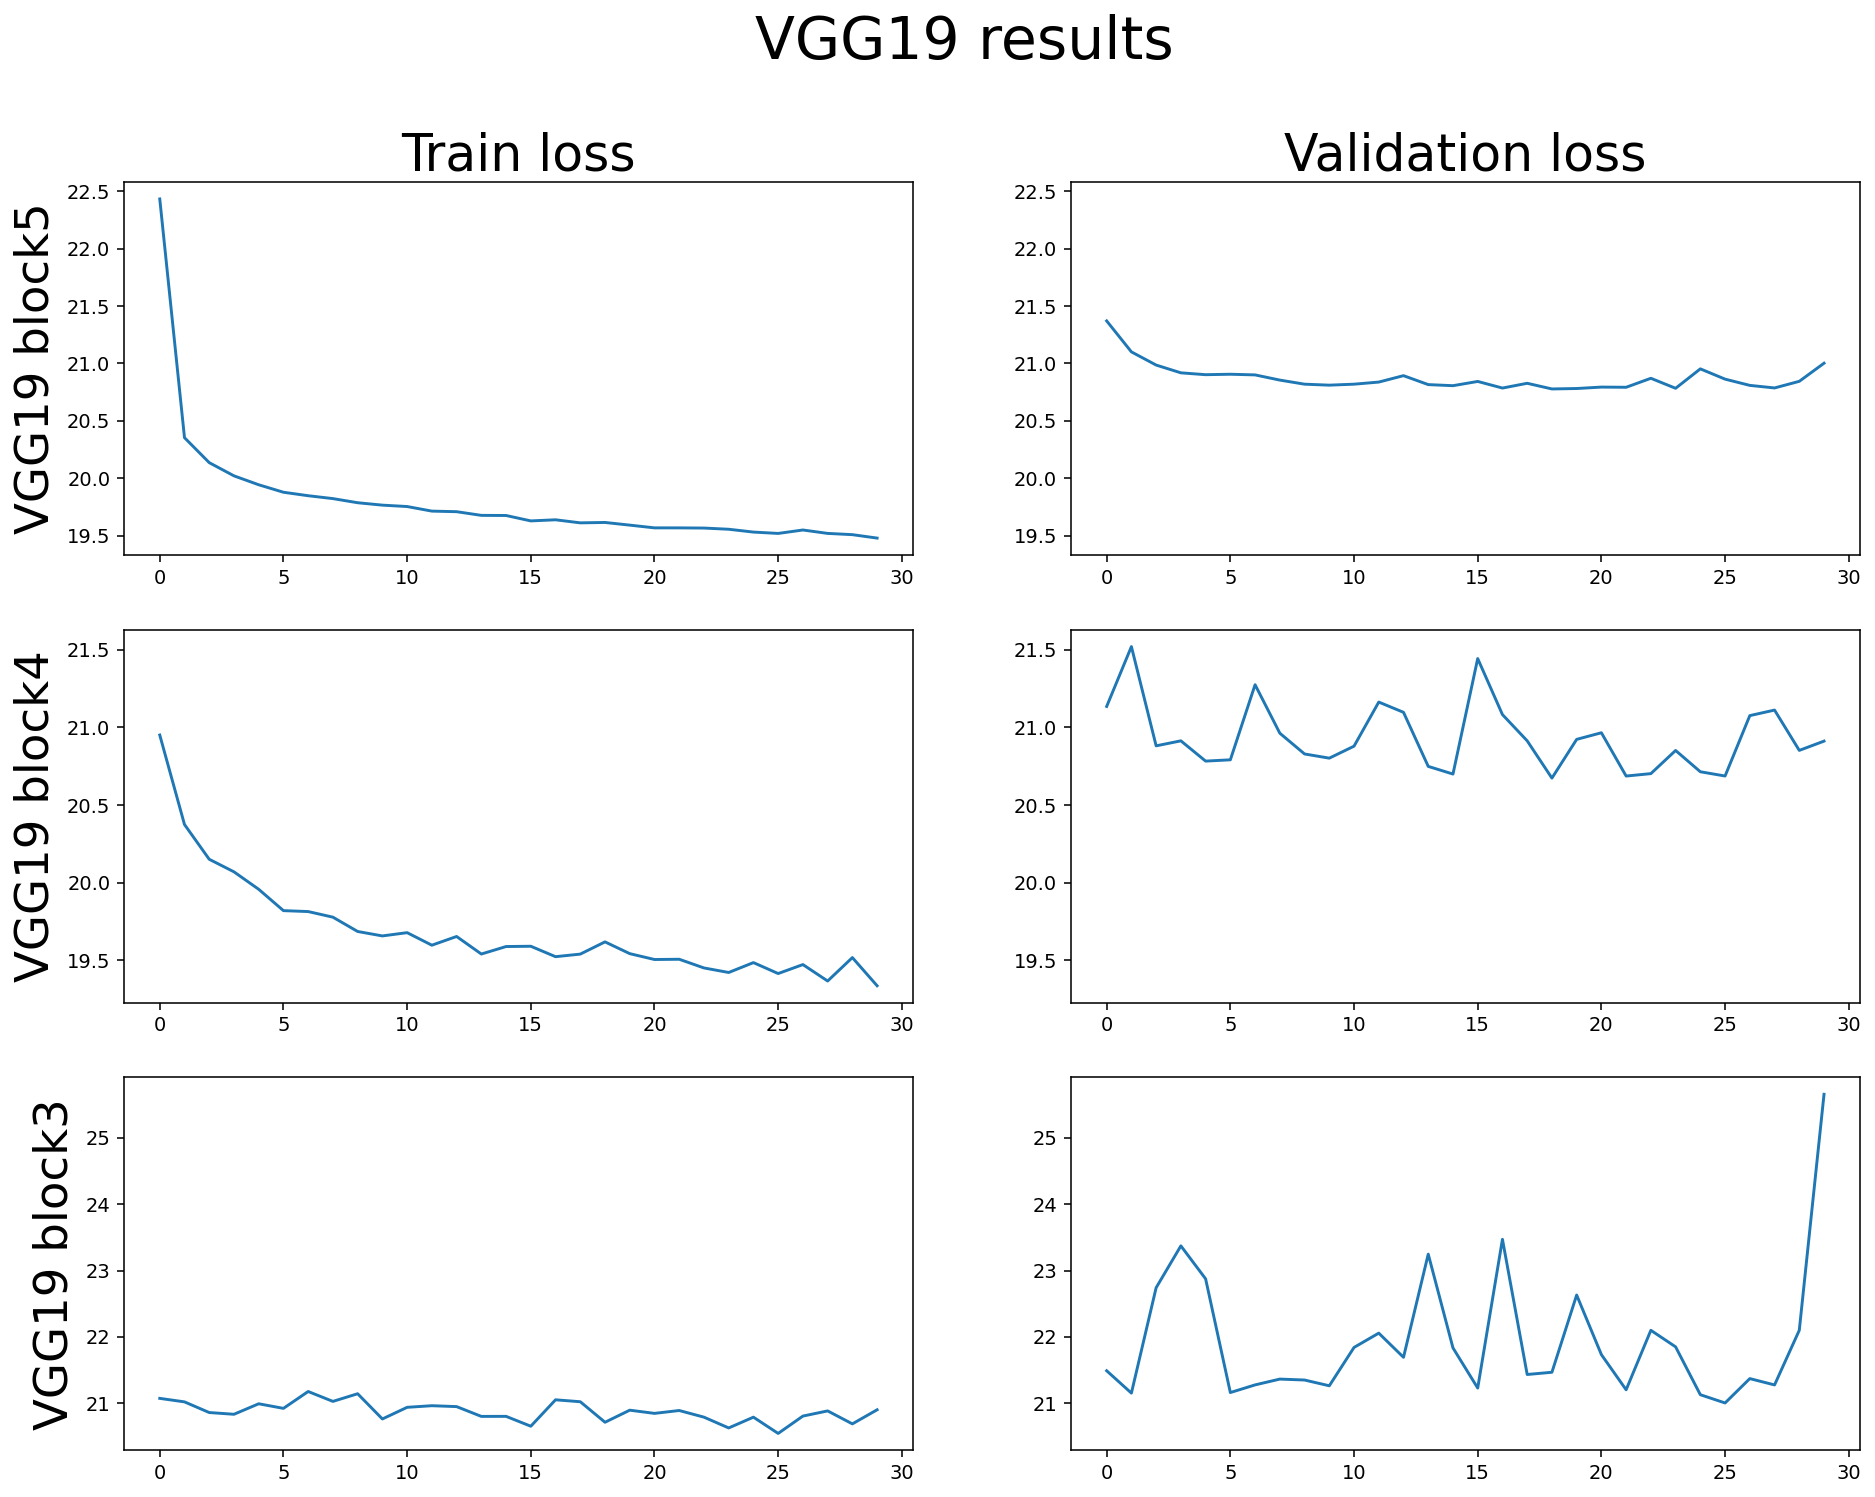

In [31]:
fig = plt.figure()
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322, sharey = ax1)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324, sharey = ax3)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326, sharey = ax5)
x = range(epoch)

ax1.set_title('Train loss', fontsize = 26)
ax1.plot(x,results_VGG19_block5.history['root_mean_squared_error'])
ax1.set_ylabel('VGG19 block5', size = 24)
ax2.set_title('Validation loss', fontsize = 26)
ax2.plot(x,results_VGG19_block5.history['val_root_mean_squared_error'])

ax3.plot(x,results_VGG19_block4.history['root_mean_squared_error'])
ax3.set_ylabel('VGG19 block4', size = 24)
ax4.plot(x,results_VGG19_block4.history['val_root_mean_squared_error'])

ax5.plot(x,results_VGG19_block3.history['root_mean_squared_error'])
ax5.set_ylabel('VGG19 block3', size = 24)
ax6.plot(x,results_VGG19_block3.history['val_root_mean_squared_error'])
fig.suptitle("VGG19 results", size = 30)
plt.show()

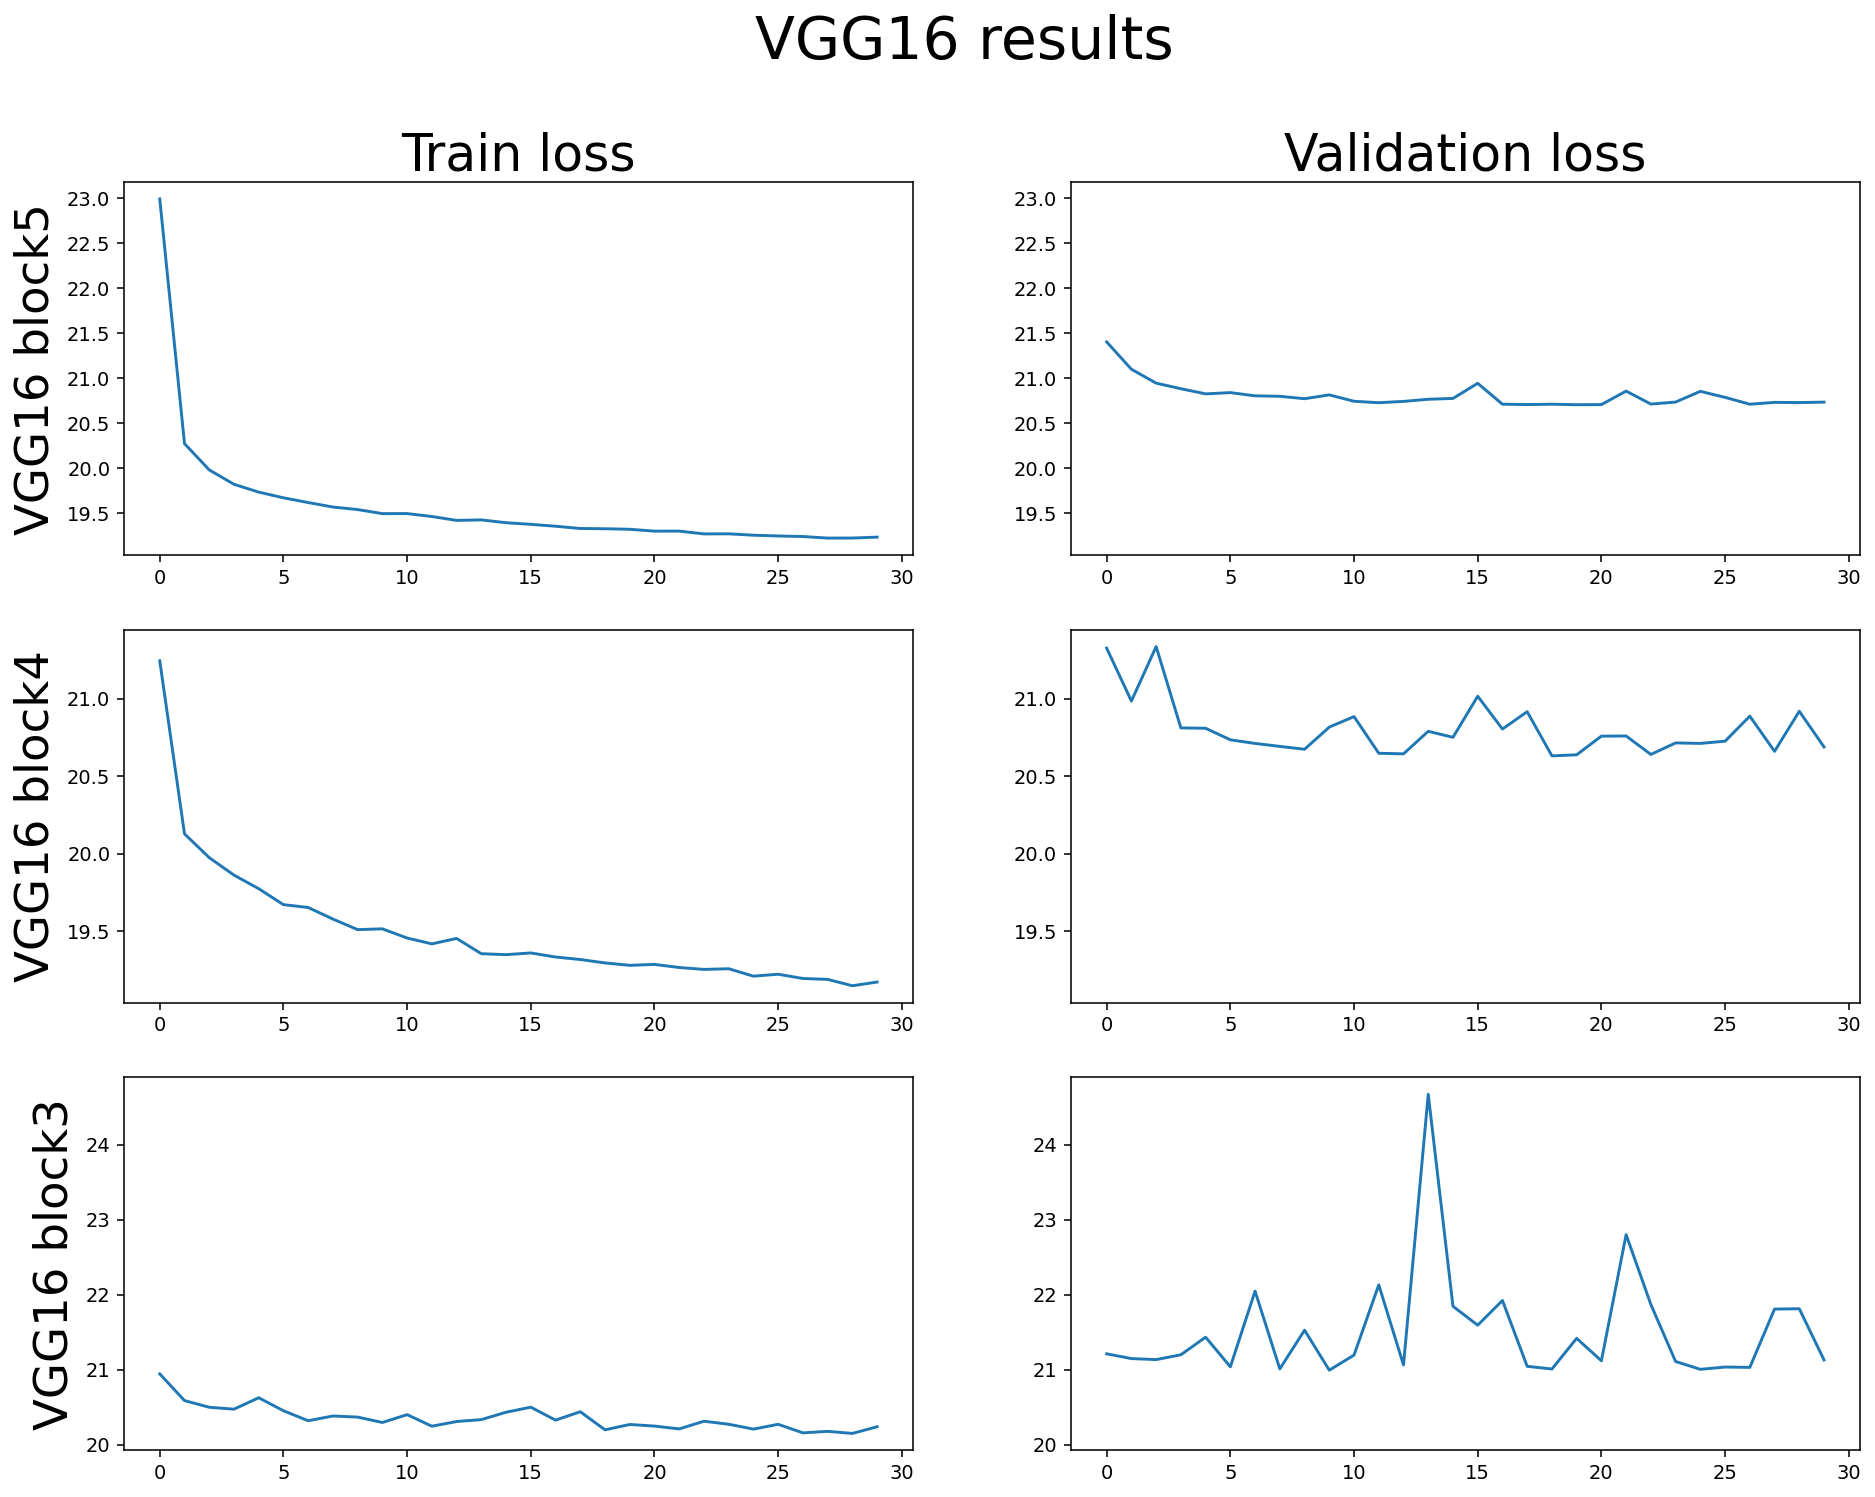

In [32]:
fig = plt.figure()
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322, sharey = ax1)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324, sharey = ax3)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326, sharey = ax5)
x = range(epoch)

ax1.set_title('Train loss', fontsize = 26)
ax1.plot(x,results_VGG16_block5.history['root_mean_squared_error'])
ax1.set_ylabel('VGG16 block5', size = 24)
ax2.set_title('Validation loss', fontsize = 26)
ax2.plot(x,results_VGG16_block5.history['val_root_mean_squared_error'])

ax3.plot(x,results_VGG16_block4.history['root_mean_squared_error'])
ax3.set_ylabel('VGG16 block4', size = 24)
ax4.plot(x,results_VGG16_block4.history['val_root_mean_squared_error'])

ax5.plot(x,results_VGG16_block3.history['root_mean_squared_error'])
ax5.set_ylabel('VGG16 block3', size = 24)
ax6.plot(x,results_VGG16_block3.history['val_root_mean_squared_error'])
fig.suptitle("VGG16 results", size = 30)
plt.show()

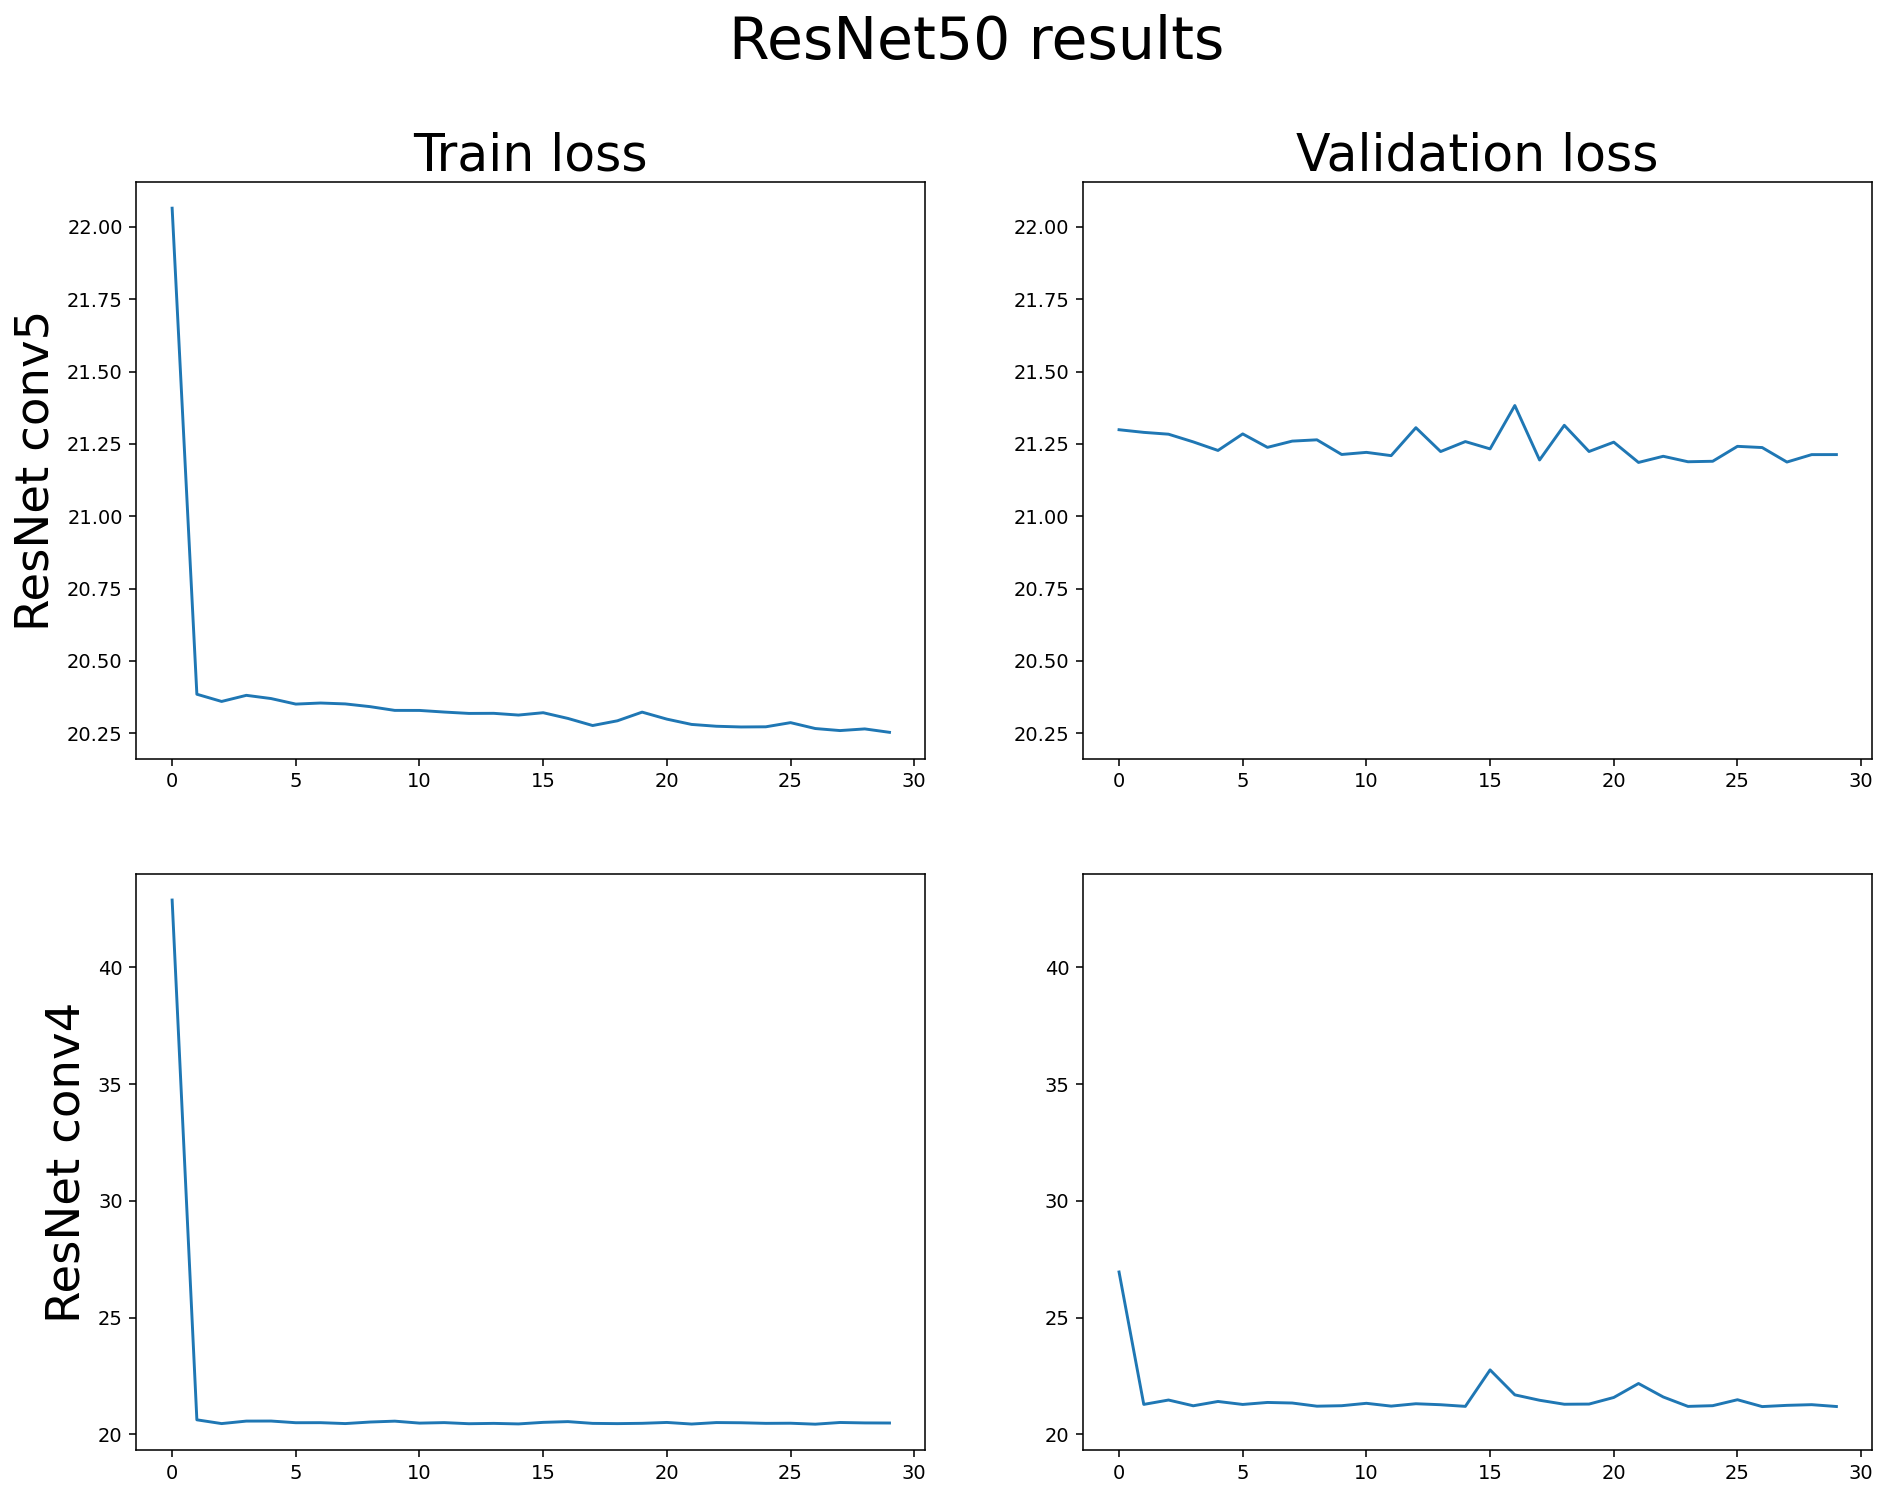

In [33]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, sharey = ax1)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224, sharey = ax3)

x = range(epoch)

ax1.set_title('Train loss', fontsize = 26)
ax1.plot(x,results_ResNet_conv5.history['root_mean_squared_error'])
ax1.set_ylabel('ResNet conv5', size = 24)
ax2.set_title('Validation loss', fontsize = 26)
ax2.plot(x,results_ResNet_conv5.history['val_root_mean_squared_error'])

ax3.plot(x,results_ResNet_conv4.history['root_mean_squared_error'])
ax3.set_ylabel('ResNet conv4', size = 24)
ax4.plot(x,results_ResNet_conv4.history['val_root_mean_squared_error'])

fig.suptitle("ResNet50 results", size = 30)
plt.show()